## Introduction

Dans le cadre du cours serie temporelle, nous avons appris a extraire la tendance de series non saisonniere au moyen de :
- Moindre carree
- Moyenne mobile
- Lissage exponnentiel
- Differenciation \

Pour mettre en pratique les notions apprisent, il nous a été demandé d'extraction de la tendance dans deux séries non saisonnière. Ainsi dans suite de notre travail in sera question d'implémenter les différentes methodes suscités, d'estimer et d'extraire la tendance de deux (2) series non saisonnière.

## Mise en place de l'environnement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

Pour la réalisation du TP nous allons utiliser les séries suivantes :\
- Données sur le GDP en inde de 1960 a 2022
- Données sur la croissance demographie d'une population

Le code suivant montre l'importation des données et la définition des constantes que nous allons manipuler tout le long de ce TP

In [2]:
FILE_LIST=["India_GDP_1960-2022.csv", "POP.csv"]
FEATURE_LIST=[#'Growth %'
    'GDP in (Billion) $'
    ,'value']
PARSE_DATE=[1,2]
ALL_ALPHA=[0.1,0.5,0.9]
ALL_ORDER=[2,4,5]

In [3]:
all_df={}
for i, file in enumerate(FILE_LIST,start=1):
    all_df[f"dataset_{i}"]=pd.read_csv(f"dataset/{file}")

In [4]:
all_df[f"dataset_{1}"].set_index('Year',inplace=True)
all_df[f"dataset_{2}"].set_index('date',inplace=True)

## Visualisation des series

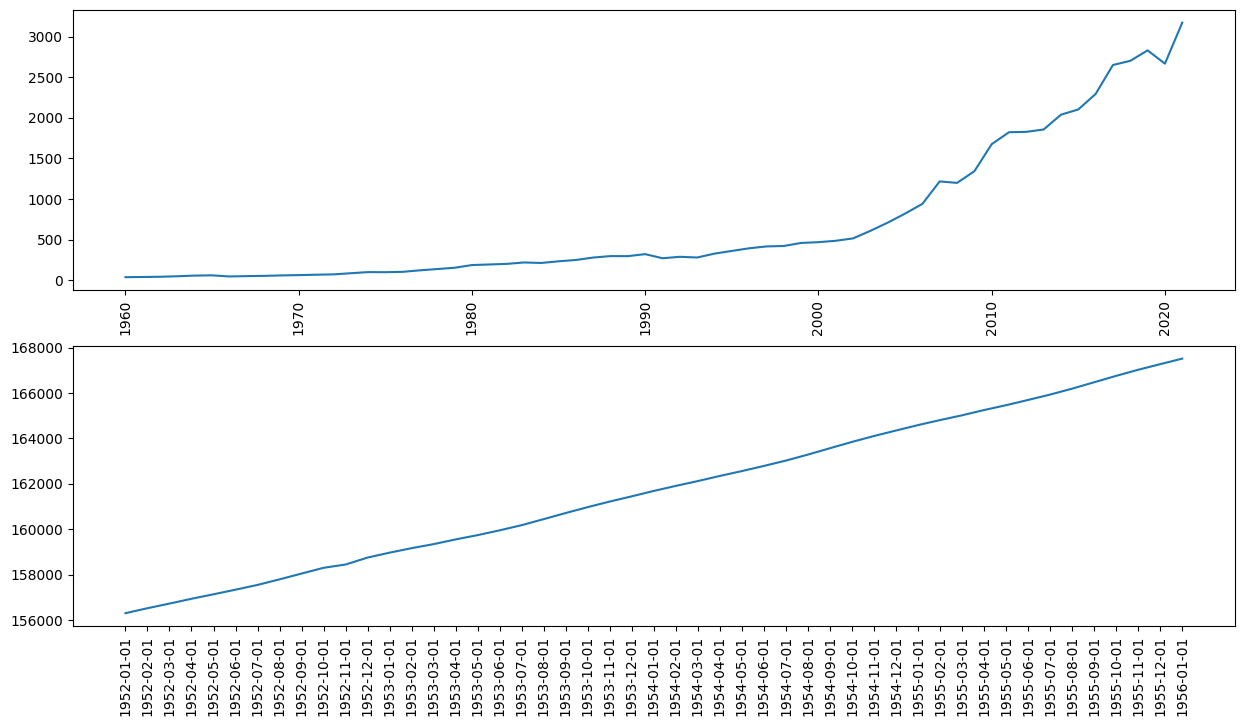

In [5]:
plt.figure(figsize=[15,8])
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    plt.plot(all_df[key][FEATURE_LIST[i-1]])
    plt.xticks(rotation=90)

## Implémentation des méthodes d'estimation de la tendance

### Lissage simple

In [6]:
class Lissage_Simple:
    def __init__(self):
        self.mt=[]
    
    def __str__(self):
        return f"{self.mt}"
        
    def predict_simple_expo_lissage(self, data, alpha, taille):
        for i in range(taille):
            if i==0:
                self.mt.append((1-alpha)*data[i])
            else:
                tmp=(1-alpha)*data[i]+alpha*self.mt[i-1]
                self.mt.append(tmp)
        return self

### Moindre carree

In [7]:
class Moindre_Carre:
    def __init__(self):
        self.mt=[]
        self.mt_hat=[]
        self.alpha=[]

    def __str__(self):
        return f"{self.mt}"

    def estimation_linear_mt(self, data, period):
        model = sm.OLS(data, period).fit()
        self.mt=list(model.predict(period))
        
        return self

    def estimation_mt_hat(self, data, period, expo):
        X=[]
        self.estimation_linear_mt(data,period)
        for mt in self.mt:
            line=[]
            for i in range(expo+1):
                line.append(mt**i)
            X.append(line)
        X=np.array(X)
        Y=np.array(data)
        self.alpha=np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),Y)
        self.mt_hat=np.dot(X,self.alpha)
        return self

### Moyenne mobile

In [8]:
class Moyenne_Mobile:
    def __init__(self, ordre):
        self.mt=[]
        self.ordre=ordre

    def compute(self,data):
        last=0
        n=self.ordre//2
        for pas in range(2*n+1,len(data)):
            X=data[last:pas]
            if self.ordre%2==1:
                self.mt.append(np.sum(X)/self.ordre)
            else:
                X[0]=0.5*X[0]
                X[-1]=0.5*X[-1]
                self.mt.append(np.sum(X)/self.ordre)
            last+=1

### Estimation de la tendance des deux séries 

In [9]:
all_result1={}
data=np.array(all_df['dataset_1'][FEATURE_LIST[0]])
#Lissage Simple
lissage={}
for alpha in ALL_ALPHA:
    lissage[alpha]=Lissage_Simple()
    lissage[alpha].predict_simple_expo_lissage(data, alpha, len(data))
all_result1['Lissage_Simple']=lissage

#Moindre Carree
period=list(all_df['dataset_1'].index)
moindre_carree=Moindre_Carre()
moindre_carree.estimation_mt_hat(data, period,4)
all_result1['Moindre_carree']=moindre_carree

#Moyenne Mobile
moyenne_mobile={}
for order in ALL_ORDER:
    moyenne_mobile[order]=Moyenne_Mobile(order)
    moyenne_mobile[order].compute(data)
all_result1['Moyenne_Mobile']=moyenne_mobile

In [10]:
all_result2={}
data=np.array(all_df['dataset_2'][FEATURE_LIST[1]])
#Lissage Simple
lissage={}
for alpha in ALL_ALPHA:
    lissage[alpha]=Lissage_Simple()
    lissage[alpha].predict_simple_expo_lissage(data, alpha, len(data))
all_result2['Lissage_Simple']=lissage

#Moindre Carree
period=list(np.linspace(1,len(data),len(data)))
moindre_carree=Moindre_Carre()
moindre_carree.estimation_mt_hat(data, period,4)
all_result2['Moindre_carree']=moindre_carree

#Moyenne Mobile
moyenne_mobile={}
for order in ALL_ORDER:
    moyenne_mobile[order]=Moyenne_Mobile(order)
    moyenne_mobile[order].compute(data)
all_result2['Moyenne_Mobile']=moyenne_mobile

In [11]:
all_results={'dataset_1':all_result1,'dataset_2':all_result2}

#### Lissage simple

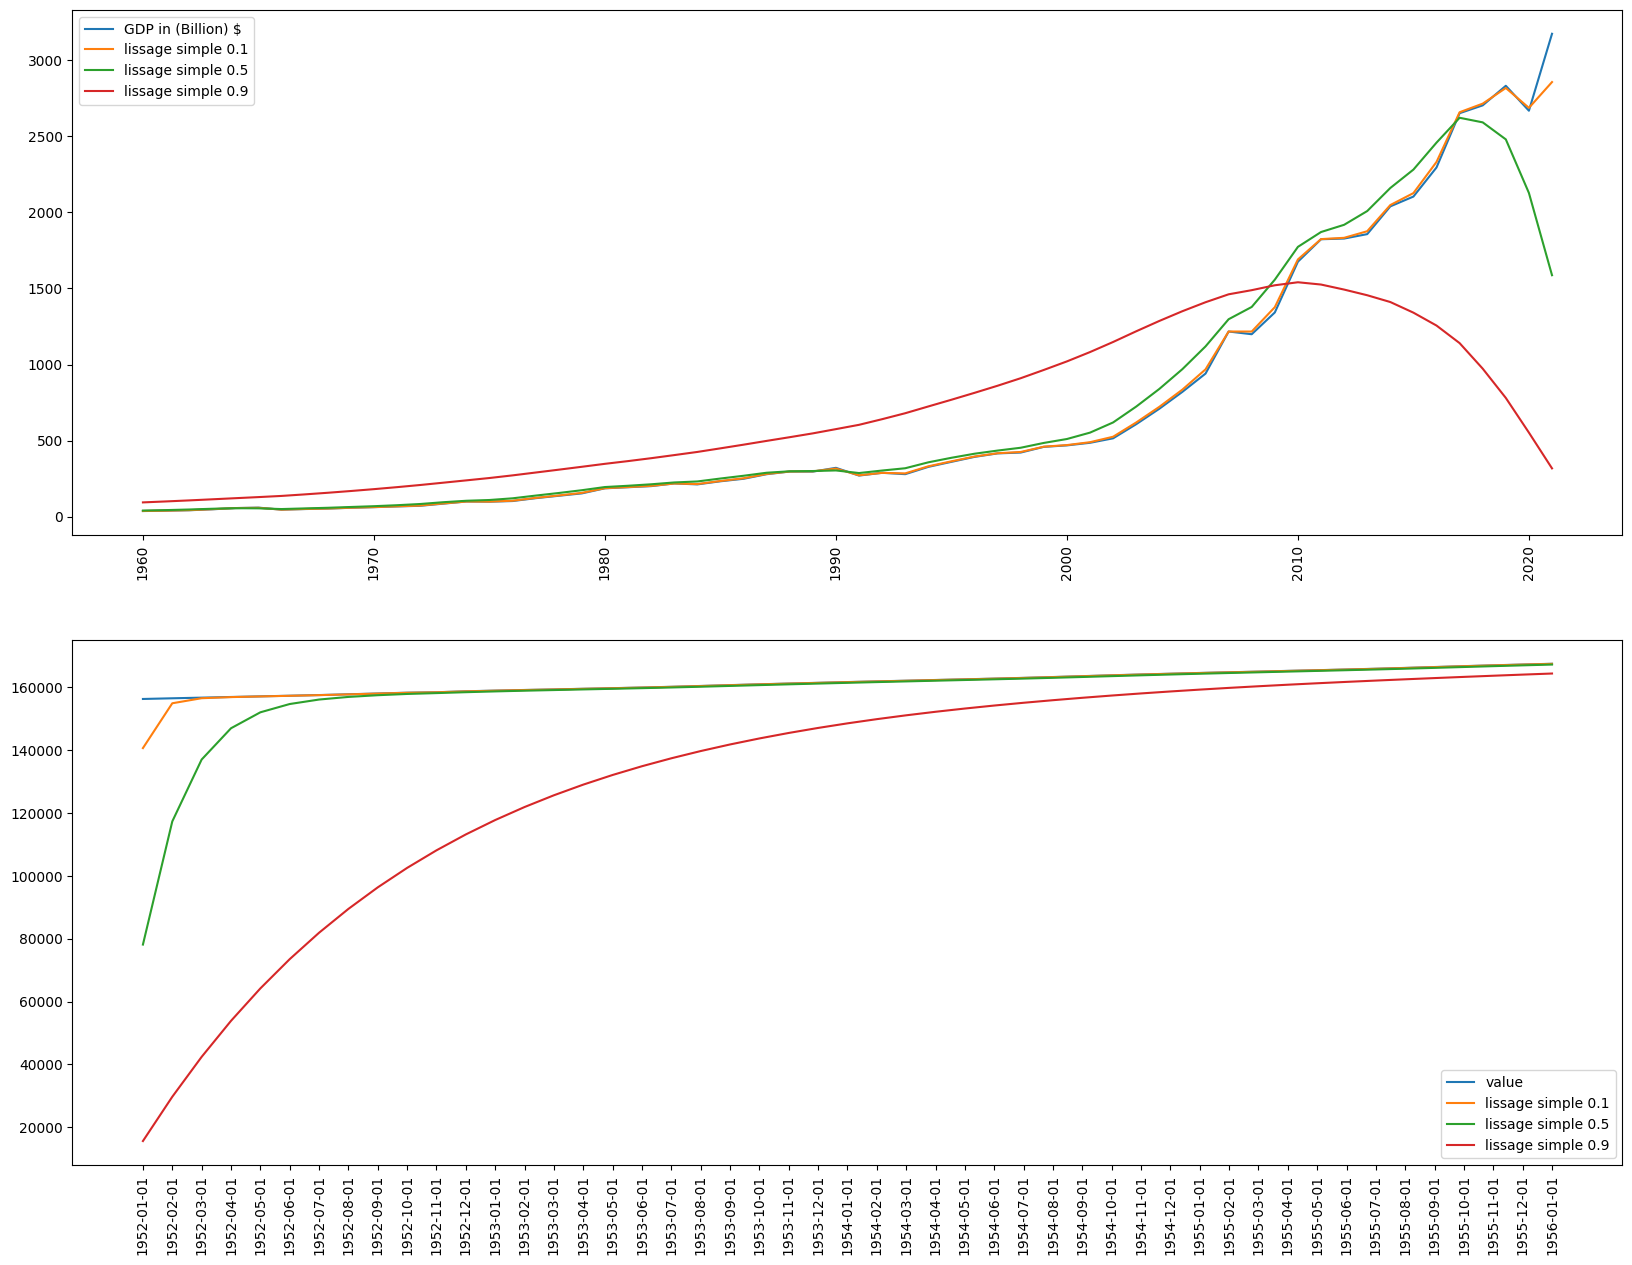

In [12]:
plt.figure(figsize=[20,15])
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    plt.plot(all_df[key][FEATURE_LIST[i-1]], label=FEATURE_LIST[i-1])
    #Lissage Simple
    for key2 in all_results['dataset_1']['Lissage_Simple'].keys():
        plt.plot(all_df[key].index, all_results[key]['Lissage_Simple'][key2].mt, label=f'lissage simple {key2}')    
        
    plt.xticks(rotation=90)
    plt.legend()

#### Moindre carree

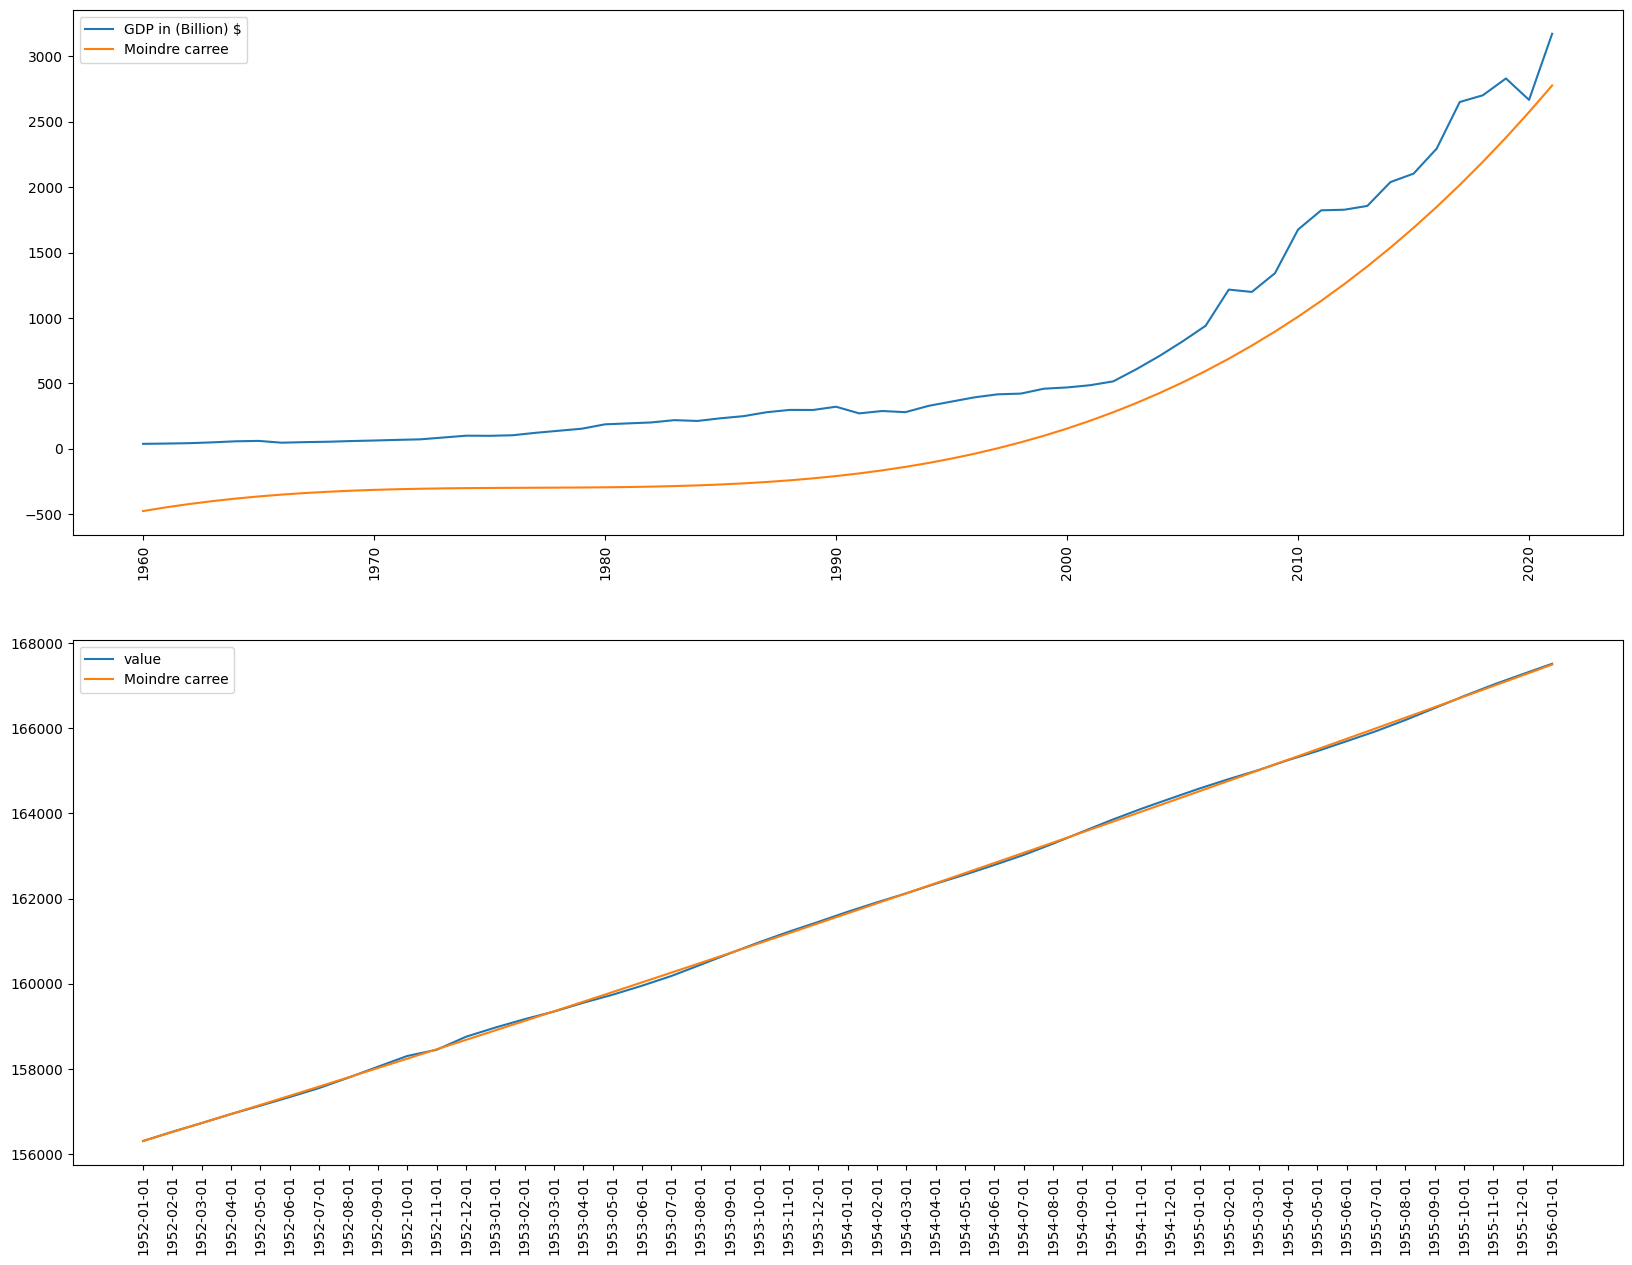

In [13]:
plt.figure(figsize=[20,15])
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    plt.plot(all_df[key][FEATURE_LIST[i-1]], label=FEATURE_LIST[i-1])   
    
    #Moindre Carree
    plt.plot(all_df[key].index, all_results[key]['Moindre_carree'].mt_hat, label='Moindre carree')    
        
    plt.xticks(rotation=90)
    plt.legend()

#### Moyenne mobile

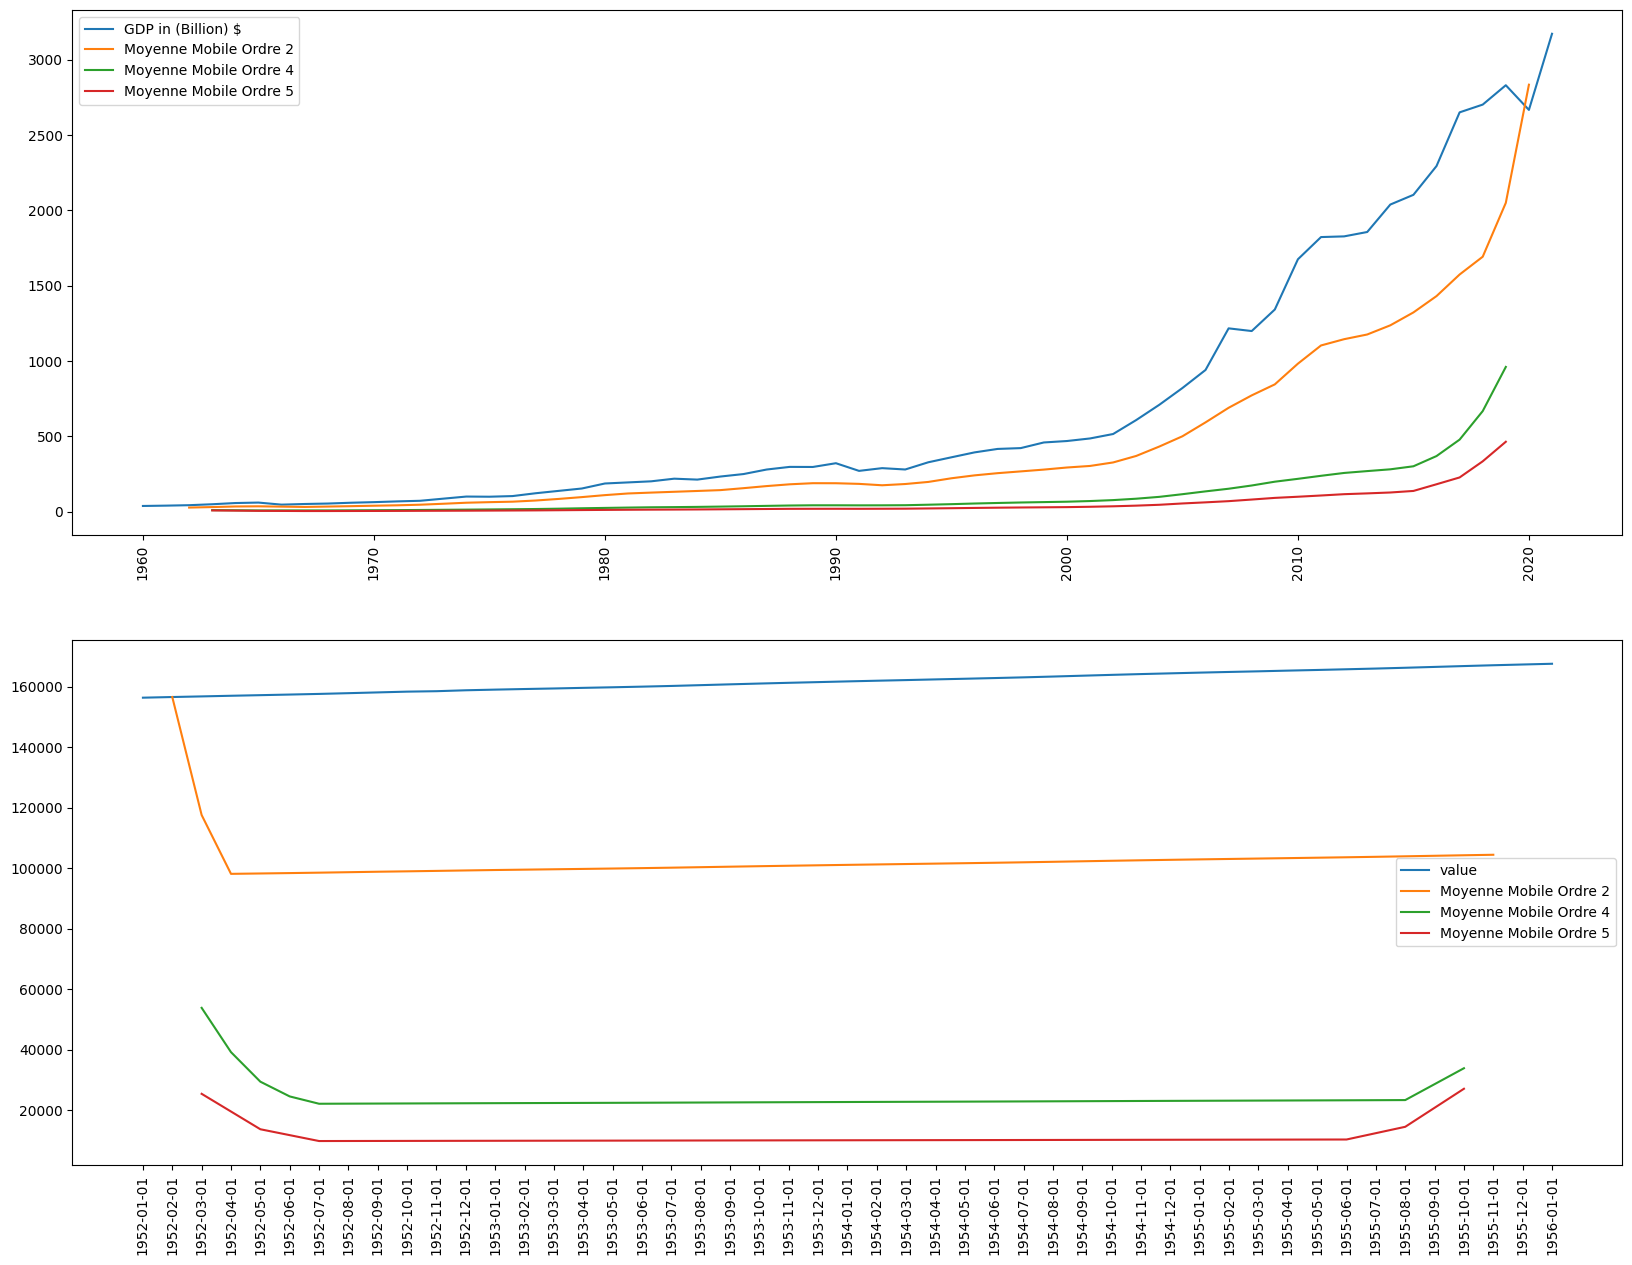

In [14]:
plt.figure(figsize=[20,15])
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    plt.plot(all_df[key][FEATURE_LIST[i-1]], label=FEATURE_LIST[i-1])   
    
    #Moyenne Mobile
    X=list(all_df[key].index)
    for key2 in all_results['dataset_1']['Moyenne_Mobile'].keys():
        taille=len(all_results[key]['Moyenne_Mobile'][key2].mt)
        d=int(key2)//2
        plt.plot(X[d:taille+d], all_results[key]['Moyenne_Mobile'][key2].mt, label=f'Moyenne Mobile Ordre {key2}') 
        
    plt.xticks(rotation=90)
    plt.legend()

## Extraction de la tendance

### Methode de differenciaion

In [15]:
class Differenciation:
    def __init__(self, ordre):
        self.diff=[]
        self.ordre=ordre

    def compute(self, data):
        self.diff=np.copy(data)
        for i in range(self.ordre):
            self.diff=np.diff(self.diff)

        return self
            

### En utilisant les méthodes d'estimations de la tendance

In [16]:
def compute_residu(data, trend):
    return data-trend

### Série corrigé de tendance 

In [17]:
all_residu={}
for i, key in enumerate(all_df.keys(),start=1):
    tmp={}
    data=np.array(all_df[key][FEATURE_LIST[i-1]])
    #Lissage Simple
    for key2 in all_results['dataset_1']['Lissage_Simple'].keys():
        trend=np.array(all_results[key]['Lissage_Simple'][key2].mt)
        tmp[f'lissage simple {key2}']=compute_residu(data, trend)
    
    #Moindre Carree
    trend=np.array(all_results[key]['Moindre_carree'].mt_hat)
    tmp['Moindre carree']= compute_residu(data, trend)

    
    #Moyenne Mobile
    X=list(all_df[key].index)
    for key2 in all_results['dataset_1']['Moyenne_Mobile'].keys():
        taille=len(all_results[key]['Moyenne_Mobile'][key2].mt)
        d=int(key2)//2
        trend=np.array(all_results[key]['Moyenne_Mobile'][key2].mt)
        tmp[f'Moyenne Mobile Ordre {key2}']=compute_residu(data[d:taille+d], trend) 

    #Differnciation
    for order in ALL_ORDER:
        res=Differenciation(order)
        res.compute(data)
        tmp[f"Differenciation {order}"]=res.diff
        
    all_residu[key]=tmp

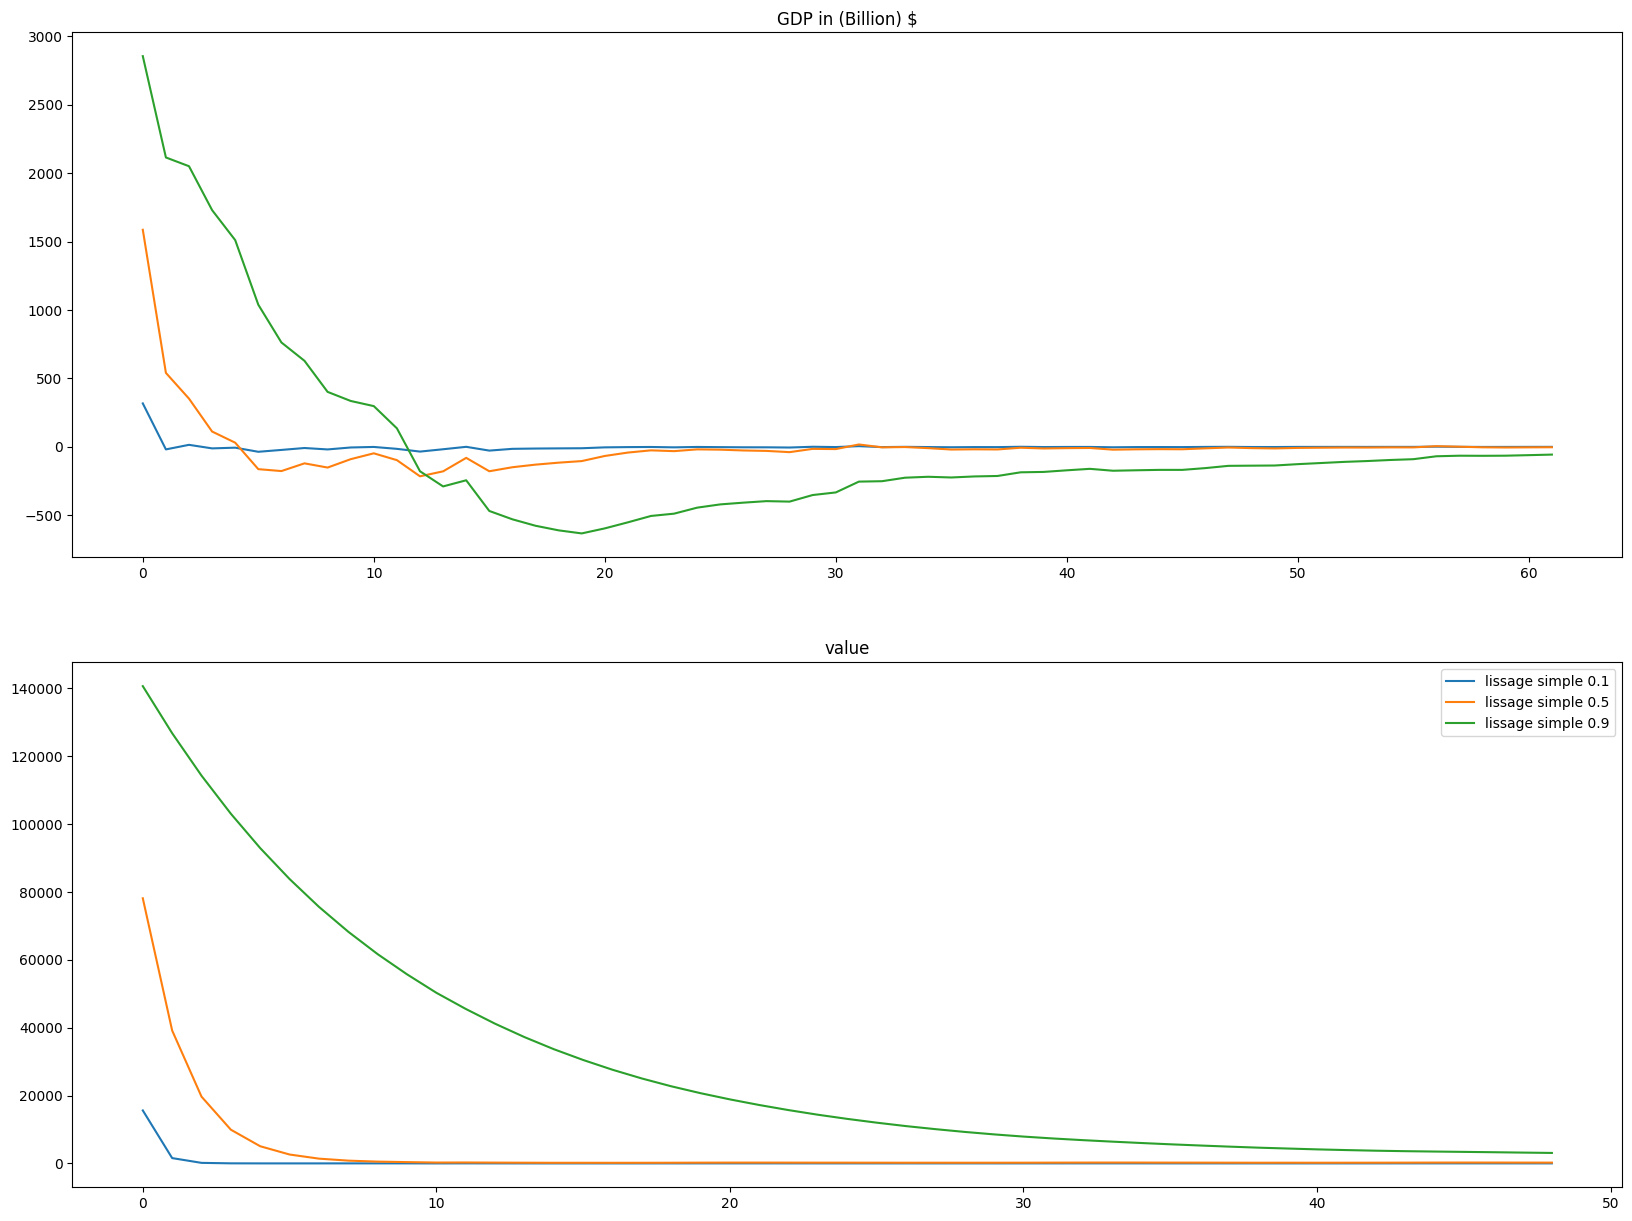

In [18]:
plt.figure(figsize=[20,15])
keylist=['lissage simple 0.1', 'lissage simple 0.5', 'lissage simple 0.9']
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    for key2 in keylist:
        plt.plot(all_residu[key][key2], label=key2)
    plt.title(FEATURE_LIST[i-1])

plt.legend()

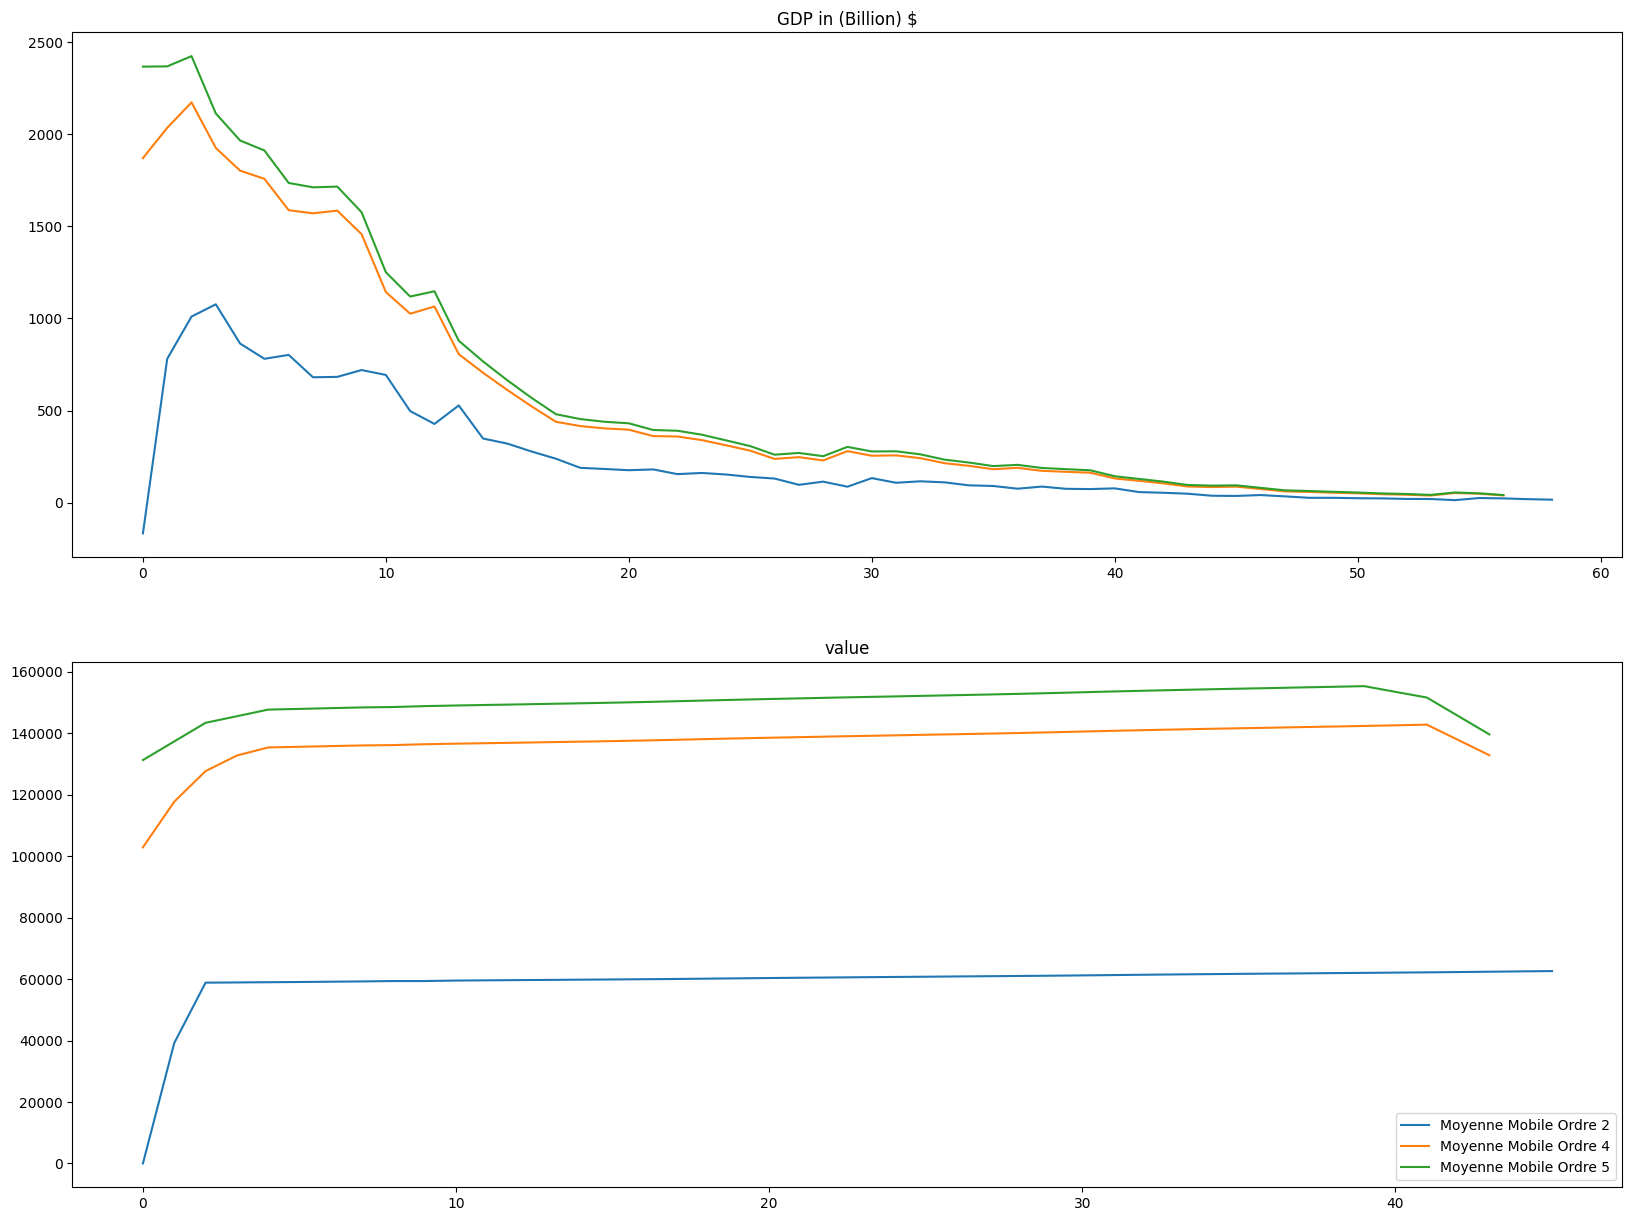

In [19]:
plt.figure(figsize=[20,15])
keylist=['Moyenne Mobile Ordre 2', 'Moyenne Mobile Ordre 4','Moyenne Mobile Ordre 5']
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    for key2 in keylist:
        plt.plot(all_residu[key][key2], label=key2)
    plt.title(FEATURE_LIST[i-1])

plt.legend()

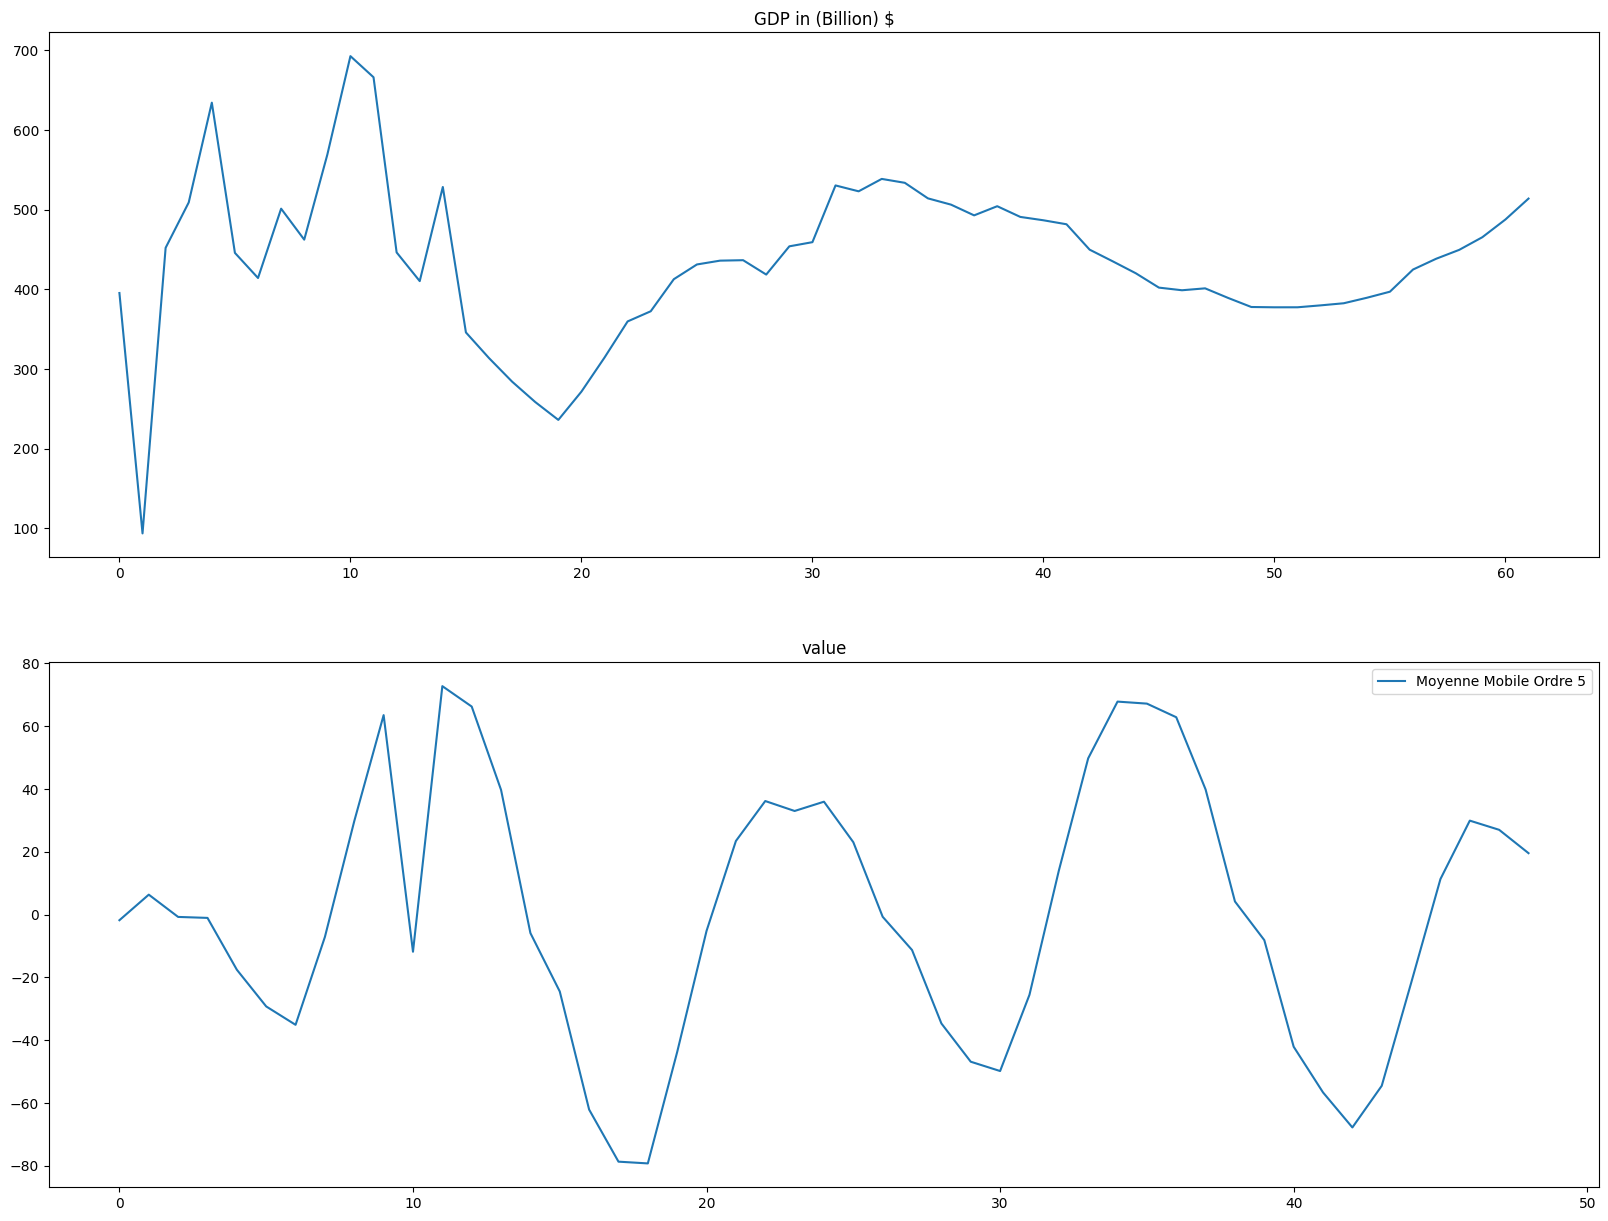

In [20]:
plt.figure(figsize=[20,15])
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    plt.plot(all_residu[key]['Moindre carree'], label=key2)
    plt.title(FEATURE_LIST[i-1])

plt.legend()

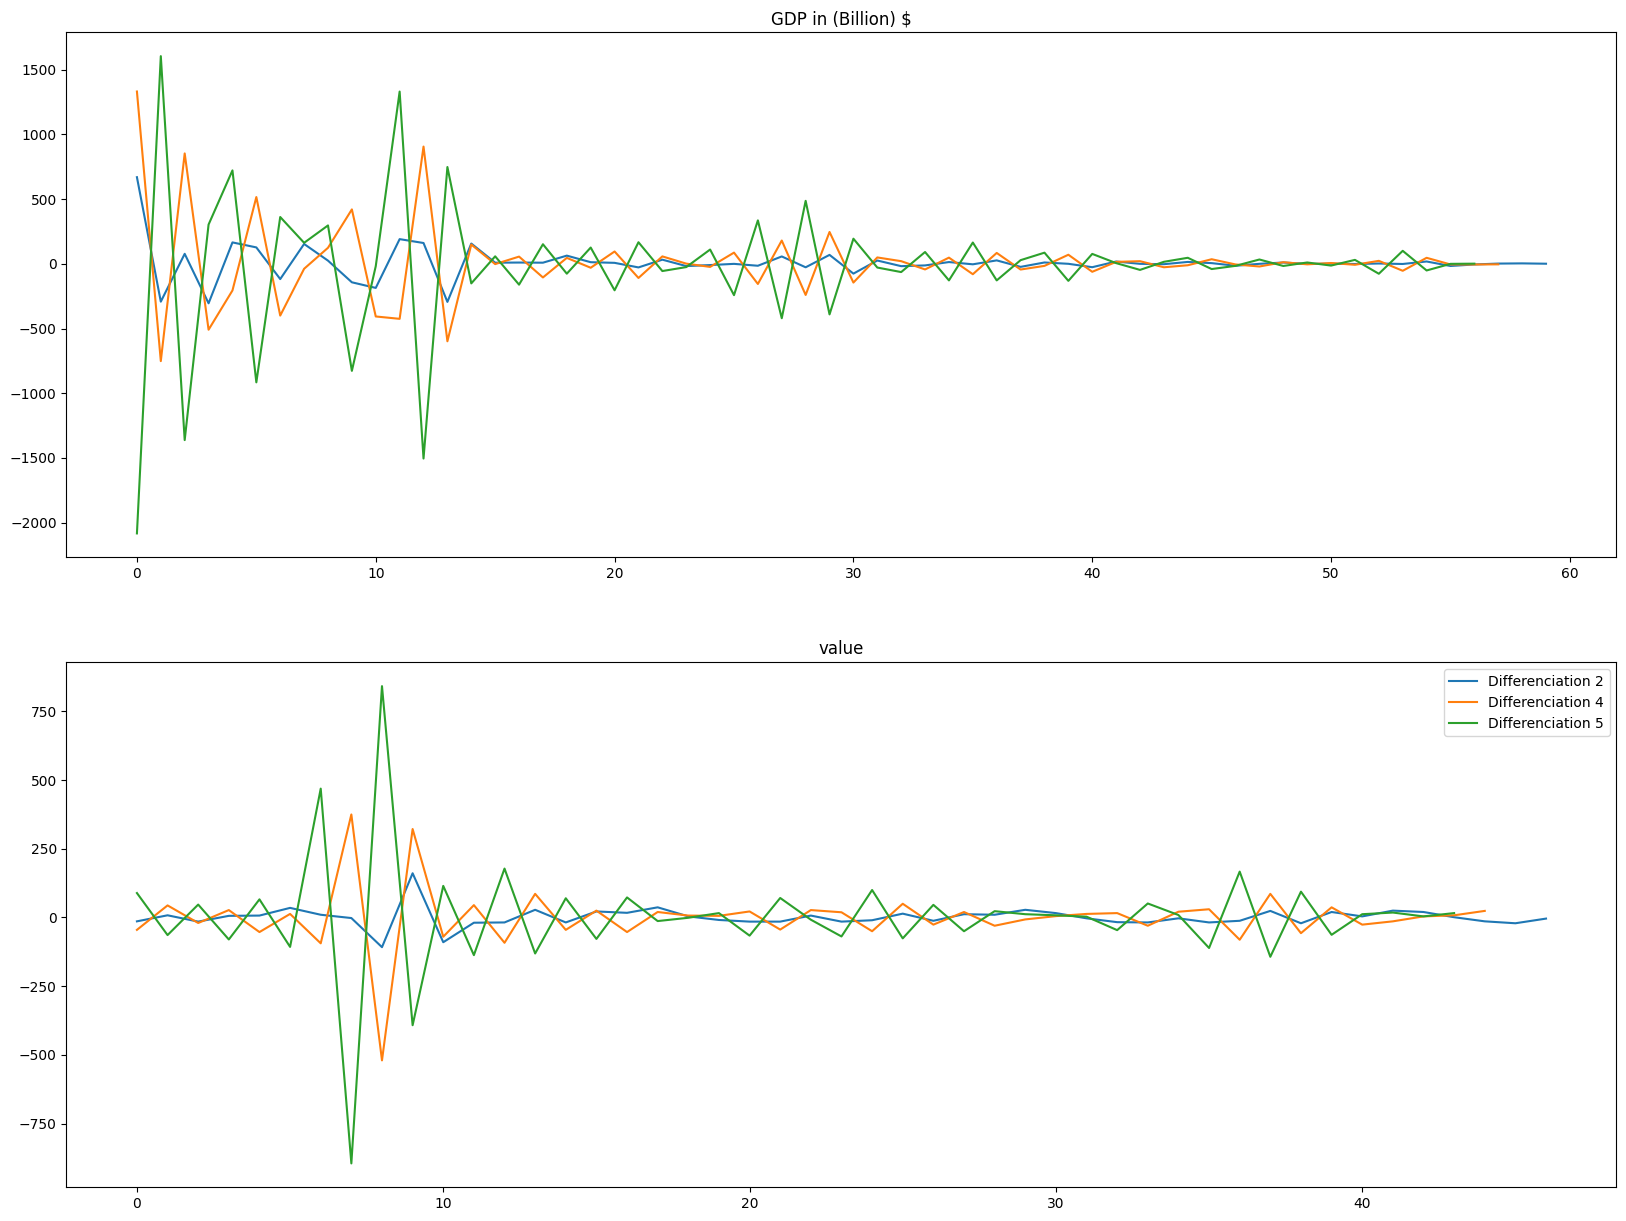

In [21]:
keylist=['Differenciation 2', 'Differenciation 4', 'Differenciation 5']
plt.figure(figsize=[20,15])
for i, key in enumerate(all_df.keys(),start=1):
    plt.subplot(2,1,i)
    for key2 in keylist:
        plt.plot(all_residu[key][key2], label=key2)
    plt.title(FEATURE_LIST[i-1])

plt.legend()